## Purpose of the notebook
1. reduce the number of features with PCA to 20
2. split the data on train-val-test sets
3. prepare the data and parameters for random forest classifier fitting
4. tune parameters on validation data
5. test the best model on the test data
6. final model evaluation based on established metrics

In [1]:
import pandas as pd
df = pd.read_csv('../../Data_processed/dif_abs_value_full_040720.csv')
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,354,355,356,357,358,359,Patient_number,Label,Label_class,Output_label
0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,-0.010,-0.010,0.000,0.005,0.005,0.015,100,N,N,0.0
1,1,0.005,-0.025,-0.015,0.000,-0.010,0.005,-0.005,-0.005,-0.010,...,0.000,0.000,-0.025,0.010,0.005,0.005,100,N,N,0.0
2,2,-0.005,-0.005,0.005,-0.025,-0.015,-0.010,0.005,0.010,0.000,...,-0.005,0.005,0.015,-0.010,-0.005,-0.015,100,N,N,0.0
3,3,-0.015,-0.015,-0.020,-0.005,-0.005,0.005,0.000,-0.010,-0.005,...,0.005,-0.005,-0.015,0.020,0.000,0.010,100,N,N,0.0
4,4,-0.005,0.005,0.005,-0.010,-0.020,-0.010,0.015,-0.005,-0.010,...,0.010,0.010,0.020,-0.010,-0.005,-0.005,100,N,N,0.0


### 1. Perform feature reduction with PCA

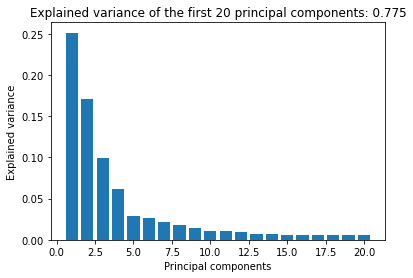

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
X = df.drop(columns = ['Unnamed: 0', 'Patient_number', 'Label', 'Label_class', 'Output_label'], axis=1)
y = df['Output_label']
target_names = ['N', 'S', 'V', 'F']
pca = PCA(n_components=20)
X_r = pca.fit(X).transform(X)
plt.bar(list(range(1,21)), pca.explained_variance_ratio_)
plt.xlabel('Principal components')
plt.ylabel('Explained variance')
explained_var = np.sum(pca.explained_variance_ratio_)
title = "Explained variance of the first 20 principal components: {}".format(round(explained_var,3))
plt.title(title)
plt.show()

### 2. split the data on train-val-test sets

In [3]:
train = [101, 103, 105, 106, 109, 111, 112, 113, 115, 116, 117, 119, 121, 122, 123,\
         200, 201, 202, 205, 207, 208, 209, 212, 219, 221, 222, 230, 231, 232, 233]
    
val = [100, 124, 215, 223]

test = [108, 114, 118, 203, 210, 213, 214, 220, 228, 234]

In [4]:
# construct a dataframe from the reduced feature array
df_r = pd.DataFrame(X_r)
df_r.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.050786,0.391651,-0.178485,0.306758,-0.240656,0.143067,0.081154,0.022355,-0.011422,0.015360,-0.081240,0.089784,0.029540,0.028102,0.001816,-0.042819,-0.036326,-0.035999,0.013668,-0.048673
1,0.297323,0.138319,-0.148956,0.190143,-0.087654,0.079699,-0.038270,-0.043619,-0.030913,0.028172,0.024244,-0.037945,0.043763,0.137263,0.048397,0.021494,0.001753,0.033310,-0.027525,0.038762
2,0.235598,0.441948,-0.274324,0.107976,-0.310303,-0.190474,0.097972,0.196435,0.102749,-0.187133,0.087316,0.037690,-0.007922,-0.048522,-0.008264,0.046134,0.019812,0.044197,-0.038786,0.047703
3,0.227483,0.463418,-0.216962,0.109937,-0.246306,-0.145597,0.037086,0.182033,0.067625,-0.214047,0.087901,0.077118,-0.019643,0.073498,-0.026452,-0.038292,0.003291,0.083087,0.037907,0.011448
4,0.063840,0.491614,-0.152614,0.211571,-0.335745,0.065443,0.120603,0.094058,0.053513,0.009773,-0.062026,0.190344,-0.069697,-0.128592,-0.034538,0.029561,0.025915,-0.023144,0.027621,-0.093105


In [5]:
# add the patient number and output label to the dataframe
df_r = pd.concat([df_r, df[['Patient_number', 'Output_label']]], axis=1)
df_r.values.shape

(100718, 22)

In [6]:
# split the data between train-val-test
df_r_train = df_r.loc[df_r['Patient_number'].isin(train)]
df_r_val = df_r.loc[df_r['Patient_number'].isin(val)]
df_r_test = df_r.loc[df_r['Patient_number'].isin(test)]

### 3. prepare the data and parameters for random forest classifier fitting

In [7]:
# get all the samples as a numpy array
x_train = df_r_train.drop(['Patient_number', 'Output_label'], axis=1).values
x_val = df_r_val.drop(['Patient_number', 'Output_label'], axis=1).values
x_test = df_r_test.drop(['Patient_number', 'Output_label'], axis=1).values

# for multilabel classification the label vector needs to be one-hot encoded
y_train = pd.get_dummies(df_r_train.Output_label).values
y_val = pd.get_dummies(df_r_val.Output_label).values
y_test = pd.get_dummies(df_r_test.Output_label).values

# inspect resulting array sizes
print("Training data:")
print("X", x_train.shape)
print("y", y_train.shape)
print("Validation data:")
print("X", x_val.shape)
print("y", y_val.shape)
print("Testing data:")
print("X", x_test.shape)
print("y", y_test.shape)

Training data:
X (66947, 20)
y (66947, 4)
Validation data:
X (9860, 20)
y (9860, 4)
Testing data:
X (23911, 20)
y (23911, 4)


In [68]:
# function for score evaluation - f1 score (without class N) 
epsilon = np.finfo(float).eps
def f1_metric(y_true, y_pred):
    true_positives = np.sum(y_true[1:,1:] * y_pred[1:,1:])
    possible_positives = np.sum(y_true[:,1:])
    predicted_positives = np.sum(y_pred[:,1:])
    precision = true_positives/(predicted_positives+epsilon)
    recall = true_positives/(possible_positives+epsilon)
    f1_val = 2*(precision*recall)/(precision+recall+epsilon)
    return f1_val

### 4. tune parameters on validation data

In [73]:
random_state=2020
class_weight='balanced_subsample'
n_estimators=[25, 50, 100, 200]
max_depth=[1, 3, 9, 27]
f1_scores_train = []
f1_scores_val = []

for n in n_estimators:
    for m in max_depth:
        print("Traning classifier with n_estimators {} and max_depth {}.".format(n,m))
        clf = RandomForestClassifier(random_state=random_state, class_weight=class_weight,\
                                     n_estimators=n, max_depth=m)
        # train the model
        clf.fit(x_train, y_train)

        # predict classes for samples in train and val
        y_pred_train = clf.predict(x_train)
        y_pred_val = clf.predict(x_val)

        # compute the confusion matrix for validation data
        cm = confusion_matrix(y_val.argmax(axis=1), y_pred_val.argmax(axis=1))
        print(cm)
        f1_score_train = f1_metric(y_train, y_pred_train)
        f1_score_val = f1_metric(y_val, y_pred_val)
        f1_scores_train.append(f1_score_train)
        f1_scores_val.append(f1_score_val)

Traning classifier with n_estimators 25 and max_depth 1.
[[9012    0    0    3]
 [ 140    0    0    0]
 [ 634    0    0   51]
 [  20    0    0    0]]
Traning classifier with n_estimators 25 and max_depth 3.
[[5068 3879   15   53]
 [ 106   33    0    1]
 [ 496   42   92   55]
 [  17    1    2    0]]
Traning classifier with n_estimators 25 and max_depth 9.
[[6094 2726  192    3]
 [ 104   27    9    0]
 [ 405   33  238    9]
 [  11    1    8    0]]
Traning classifier with n_estimators 25 and max_depth 27.
[[9010    2    3    0]
 [ 140    0    0    0]
 [ 543    0  141    1]
 [  15    0    5    0]]
Traning classifier with n_estimators 50 and max_depth 1.
[[9011    0    0    4]
 [ 140    0    0    0]
 [ 635    0    0   50]
 [  20    0    0    0]]
Traning classifier with n_estimators 50 and max_depth 3.
[[4523 4443   15   34]
 [  92   47    0    1]
 [ 493   47   91   54]
 [  16    0    4    0]]
Traning classifier with n_estimators 50 and max_depth 9.
[[6359 2535  119    2]
 [ 113   22    5   

Text(0.5, 1.0, 'Train and validation data scores')

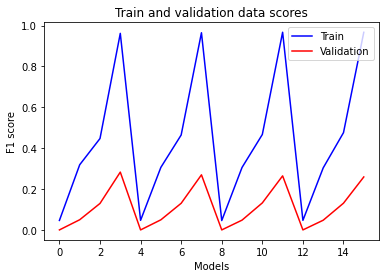

In [74]:
plt.plot(f1_scores_train, c='b', label='Train')
plt.plot(f1_scores_val, c='r', label='Validation')
plt.legend()
plt.xlabel("Models")
plt.ylabel("F1 score")
plt.title("Train and validation data scores")

In [75]:
f1_scores_val.index(max(f1_scores_val))

3

### Interpretation
Index 3 corresponds to n_estimators 25 and max_depth 27. Max_depth seams to have much more of an effect on F1 score than n_estimators based on the zig-zag pattern; each "zig" has constant n_estimator and increasing max_depth, "zag" brings the F1 score back to baseline with max_depth 1. Based on this, higher max_depth may increase the validation F1 score.

In [76]:
n_estimators=[25]
max_depth=[50, 75, 100]

for n in n_estimators:
    for m in max_depth:
        print("Traning classifier with n_estimators {} and max_depth {}.".format(n,m))
        clf = RandomForestClassifier(random_state=random_state, class_weight=class_weight,\
                                     n_estimators=n, max_depth=m)
        # train the model
        clf.fit(x_train, y_train)

        # predict classes for samples in train and val
        y_pred_train = clf.predict(x_train)
        y_pred_val = clf.predict(x_val)

        # compute the confusion matrix for validation data
        cm = confusion_matrix(y_val.argmax(axis=1), y_pred_val.argmax(axis=1))
        print(cm)
        f1_score_train = f1_metric(y_train, y_pred_train)
        f1_score_val = f1_metric(y_val, y_pred_val)
        f1_scores_train.append(f1_score_train)
        f1_scores_val.append(f1_score_val)

Traning classifier with n_estimators 25 and max_depth 50.
[[9012    0    3    0]
 [ 140    0    0    0]
 [ 543    0  141    1]
 [  15    0    5    0]]
Traning classifier with n_estimators 25 and max_depth 75.
[[9012    0    3    0]
 [ 140    0    0    0]
 [ 548    0  136    1]
 [  15    0    5    0]]
Traning classifier with n_estimators 25 and max_depth 100.
[[9012    0    3    0]
 [ 140    0    0    0]
 [ 548    0  136    1]
 [  15    0    5    0]]


Text(0.5, 1.0, 'Train and validation data scores')

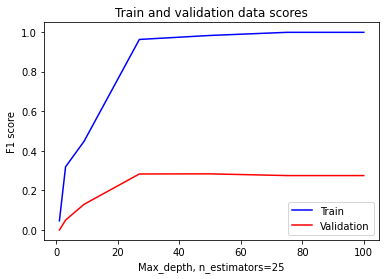

In [79]:
# plot all the models with n_estimators 25
plt.plot([1, 3, 9, 27]+[50, 75, 100], f1_scores_train[0:4]+f1_scores_train[16:19], c='b', label='Train')
plt.plot([1, 3, 9, 27]+[50, 75, 100], f1_scores_val[0:4]+f1_scores_val[16:19], c='r', label='Validation')
plt.legend()
plt.xlabel("Max_depth, n_estimators=25")
plt.ylabel("F1 score")
plt.title("Train and validation data scores")

### Interpretation
Both F1 scores keep increasing up until max_depth 27, after the model becomes overfit - further increase in train F1 score does not lead to further increase in validation F1 score. Hence, max_depth 27 is the optimum.
### 5. test the best model on test data

In [71]:
# compute base f1 score for the test data without tuning
clf = RandomForestClassifier(random_state=random_state, class_weight=class_weight)

# train the model and save for later
clf.fit(x_train, y_train)

# predict classes for samples in train and test
y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

# compute the confusion matrix for test data
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))
print(cm)
f1_score_train = f1_metric(y_train, y_pred_train)
print(f1_score_train)
f1_score_test = f1_metric(y_test, y_pred_test)
print(f1_score_test)

[[20336     0   467   861]
 [  306     0     3     2]
 [  782     0   774     0]
 [  302     0    78     0]]
1.0
0.34927797833935015


In [81]:
# compute tuned f1 score for the test data
clf = RandomForestClassifier(random_state=random_state, class_weight=class_weight, max_depth=27, n_estimators=25)

# train the model and save for later
clf.fit(x_train, y_train)

# predict classes for samples in train and test
y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

# compute the confusion matrix for test data
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_test.argmax(axis=1))
print(cm)
f1_score_train = f1_metric(y_train, y_pred_train)
print(f1_score_train)
f1_score_test = f1_metric(y_test, y_pred_test)
print(f1_score_test)

[[20114    19   538   993]
 [  304     1     3     3]
 [  730     0   826     0]
 [  297     0    83     0]]
0.9617957293542577
0.35094419690218537


In [85]:
print("% improvement in f1 score after tuning", round((0.35094419690218537-0.34927797833935015)/0.34927797833935015*100, 2))

% improvement in f1 score after tuning 0.48


### 6. final model evaluation based on established metrics

In [8]:
import numpy as np
def modelEvaluator(cm):
    epsilon =  np.finfo(float).eps
    # actual normal
    Nn = cm[0,0]
    Ns = cm[0,1]
    Nv = cm[0,2]
    Nf = cm[0,3]
    # actual Supraventricular
    Sn = cm[1,0]
    Ss = cm[1,1]
    Sv = cm[1,2]
    Sf = cm[1,3]
    # actual Ventricular
    Vn = cm[2,0]
    Vs = cm[2,1]
    Vv = cm[2,2]
    Vf = cm[2,3]
    # actual Fusion
    Fn = cm[3,0]
    Fs = cm[3,1]
    Fv = cm[3,2]
    Ff = cm[3,3]
    
    sum_all = np.sum(cm)
    # metrics for distinguishing ventricular ectopic beats
    TNv = Nn + Ns + Nf + Sn + Ss + Sf + Fn + Fs + Ff # (True negative V)
    FPv = Nv + Sv #(False positive V)
    fprV = FPv / (TNv + FPv + epsilon) #(false positive rate V)
    FNv = Vn + Vs +Vf # (False negative V)
    TPv = Vv #(True positive V)
    SeV = TPv / (TPv + FNv + epsilon) #(sensitivity or recall V)
    PrV = TPv / (TPv + FPv + epsilon) #(positive predictivity or precision V)
    AccV = (TPv + TNv) / (TPv + TNv + FPv + FNv + epsilon) #(Accuracy V)
    
    # metrics for distinguishing supraventricular ectopic beats
    TNs = Nn + Nv + Nf + Vn + Vv + Vf + Fn + Fv + Ff #(True negative S)
    FPs= Ns + Vs + Fs #(False positive S)
    fprS = FPs / (TNs + FPs + epsilon) #(false positive rate S)
    FNs = Sn + Sv +Sf #(False negative S)
    TPs = Ss #(True positive S)
    SeS = TPs / (TPs + FNs + epsilon) #( sensitivity or recall S)
    PrS = TPs / (TPs + FPs + epsilon) #(positive predictivity or precision S)
    AccS = (TPs + TNs) / (TPs + TNs + FPs + FNs + epsilon) #(Accuracy S)
    
    # metrics for distinguishing all beats
    TN = Nn #(True negative)
    TPf = Ff
    FPN = Ns + Nv + Nf # false positive N class
    Sp = TN/(TN + FPN + epsilon)
    sum_f = Fn + Fs + Fv + Ff
    SeF = TPf/(sum_f + epsilon)
    Acc = (Nn + Ss + Vv + Ff)/sum_all
    
    return_array = [round(SeV, 3), round(PrV, 3), round(fprV, 3), round(AccV, 3), round(SeS, 3), round(PrS, 3),\
                    round(fprS, 3), round(AccS, 3), round(SeF, 3), round(Sp, 3), round(Acc, 3)]
    return return_array

In [10]:
return_array = modelEvaluator(cm)
return_array = pd.Series(return_array, index=['SeV', 'PrV', 'fprV', 'AccV', 'SeS', 'PrS', 'fprS', 'AccS', 'SeF', 'Sp', 'Acc'])
return_array

SeV     0.531
PrV     0.604
fprV    0.024
AccV    0.947
SeS     0.003
PrS     0.050
fprS    0.001
AccS    0.986
SeF     0.000
Sp      0.928
Acc     0.876
dtype: float64

In [94]:
import pickle
filename = '../../models/finalized_RF_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [95]:
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=27, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=25, n_jobs=None, oob_score=False,
                       random_state=2020, verbose=0, warm_start=False)